<a href="https://colab.research.google.com/github/Cham0703/DU_AN_SPAM/blob/main/final_email_detechtion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coder 1: Hoàng
*   Xử lý dữ liệu spam (spam.csv)
*   Làm sạch văn bản
*   Khám phá dữ liệu (WordCloud, biểu đồ độ dài tin nhắn)
*   Huấn luyện mô hình Logistic Regression với TF-IDF
*   Lưu dữ liệu và mô hình



Đã đoán encoding: Windows-1252

📄 Độ dài tin nhắn - HAM:
                                             message  message_length
0  Go until jurong point, crazy.. Available only ...             111
1                      Ok lar... Joking wif u oni...              29
3  U dun say so early hor... U c already then say...              49
4  Nah I don't think he goes to usf, he lives aro...              61
6  Even my brother is not like to speak with me. ...              77

📄 Độ dài tin nhắn - SPAM:
                                              message  message_length
2   Free entry in 2 a wkly comp to win FA Cup fina...             155
5   FreeMsg Hey there darling it's been 3 week's n...             148
8   WINNER!! As a valued network customer you have...             158
9   Had your mobile 11 months or more? U R entitle...             154
11  SIX chances to win CASH! From 100 to 20,000 po...             136


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


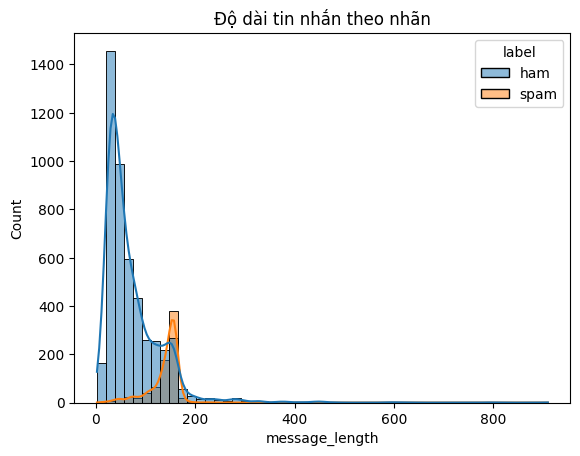


🔢 Top 10 từ SPAM phổ biến:
       word  frequency
45     call        349
34        å        270
0      free        219
52        u        155
14      txt        150
99       ur        144
50   mobile        124
11     text        121
281    stop        116
44    claim        113

🔢 Top 10 từ HAM phổ biến:
     word  frequency
20      u        988
56     im        451
242   get        307
237  ltgt        276
16     ok        272
29   dont        257
0      go        249
123    ur        240
159   ill        236
13    got        232


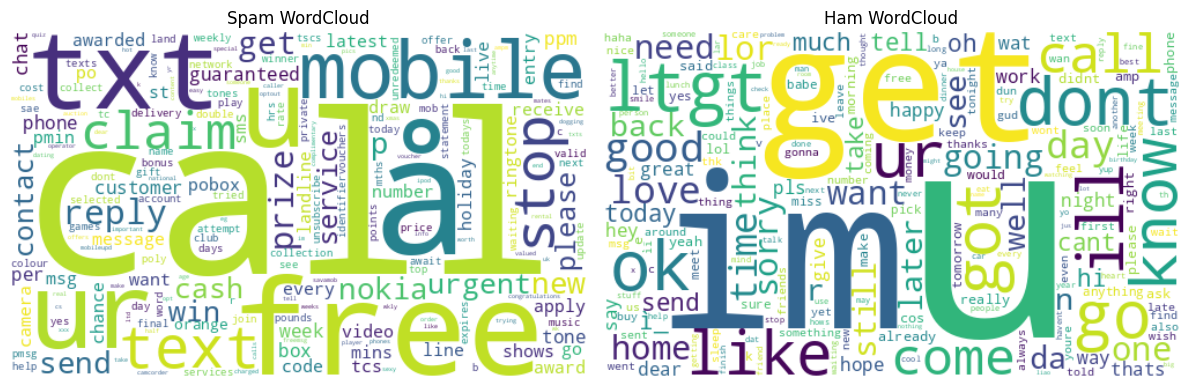


🎯 Kết quả đánh giá mô hình:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.96      0.66      0.78       150

    accuracy                           0.95      1115
   macro avg       0.96      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115

Độ chính xác: 0.9506726457399103

✅ Dữ liệu và mô hình đã được lưu vào thư mục 'processed_data'.


In [13]:
# Import thư viện
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from google.colab import drive
import os
import pickle
import numpy as np
from scipy import sparse

# BƯỚC 1: Đọc file và chuẩn hóa dữ liệu
duong_dan = "spam.csv"

with open(duong_dan, "rb") as f:
    encoding = chardet.detect(f.read(10000))['encoding']
    print(f"Đã đoán encoding: {encoding}")

df = pd.read_csv(duong_dan, encoding=encoding)[['v1', 'v2']]
df.columns = ['label', 'message']

# 🧹 BƯỚC 2: Làm sạch dữ liệu
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_message(msg):
    # Xử lý np.nan hoặc giá trị không phải chuỗi
    if not isinstance(msg, str) or pd.isna(msg):
        return ''
    msg = msg.lower()
    msg = re.sub(r'\d+', '', msg)
    msg = re.sub(r'[^\w\s]', '', msg)
    words = msg.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

# Xử lý np.nan trong message trước khi áp dụng clean_message
df['message'] = df['message'].fillna('')
df['cleaned_message'] = df['message'].apply(clean_message)

# BƯỚC 3: Khám phá dữ liệu
df['message_length'] = df['message'].apply(len)

# Tách ra 2 bảng riêng
df_ham = df[df['label'] == 'ham'][['message', 'message_length']]
df_spam = df[df['label'] == 'spam'][['message', 'message_length']]

print("\n📄 Độ dài tin nhắn - HAM:")
print(df_ham.head())
print("\n📄 Độ dài tin nhắn - SPAM:")
print(df_spam.head())

# Vẽ biểu đồ độ dài
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True)
plt.title("Độ dài tin nhắn theo nhãn")
plt.show()

# ☁️ BƯỚC 4: Tạo WordCloud + bảng tần suất
spam_words = ' '.join(df[df['label'] == 'spam']['cleaned_message']).split()
ham_words = ' '.join(df[df['label'] == 'ham']['cleaned_message']).split()

spam_freq = Counter(spam_words)
ham_freq = Counter(ham_words)

spam_freq_df = pd.DataFrame(spam_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
ham_freq_df = pd.DataFrame(ham_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Hiển thị top 10
print("\n🔢 Top 10 từ SPAM phổ biến:")
print(spam_freq_df.head(10))
print("\n🔢 Top 10 từ HAM phổ biến:")
print(ham_freq_df.head(10))

# Vẽ WordCloud
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
wordcloud_spam = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(spam_freq)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.title("Spam WordCloud")

plt.subplot(1, 2, 2)
wordcloud_ham = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(ham_freq)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis("off")
plt.title("Ham WordCloud")

plt.tight_layout()
plt.show()

# 📈 BƯỚC 5: Chuẩn bị dữ liệu huấn luyện
X = df['cleaned_message']
y = df['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# BƯỚC 6: Huấn luyện mô hình Logistic Regression
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

# 🎯 BƯỚC 7: Đánh giá mô hình
print("\n🎯 Kết quả đánh giá mô hình:")
print(classification_report(y_test, y_pred))
print("Độ chính xác:", accuracy_score(y_test, y_pred))

# Tạo thư mục lưu nếu chưa có
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# ✅ Lưu dữ liệu
sparse.save_npz(os.path.join(output_dir, "X_train_tfidf.npz"), X_train_tfidf)
sparse.save_npz(os.path.join(output_dir, "X_test_tfidf.npz"), X_test_tfidf)
np.save(os.path.join(output_dir, "y_train.npy"), y_train)
np.save(os.path.join(output_dir, "y_test.npy"), y_test)

# ✅ Lưu TF-IDF vectorizer
with open(os.path.join(output_dir, "tfidf_vectorizer.pkl"), "wb") as f:
    pickle.dump(tfidf, f)

# ✅ Lưu mô hình Logistic Regression
with open(os.path.join(output_dir, "logistic_model.pkl"), "wb") as f:
    pickle.dump(model, f)

# ✅ Lưu DataFrame
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})  # Thêm label_num
df.to_csv(os.path.join(output_dir, "cleaned_data.csv"), index=False)

print("\n✅ Dữ liệu và mô hình đã được lưu vào thư mục 'processed_data'.")

#Coder 2: Trâm

*   Tải dữ liệu đã xử lý từ Coder 1
*   Vẽ các biểu đồ phân tích (phân bố nhãn, độ dài tin nhắn, từ phổ biến)



In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from scipy import sparse

# 4. Định nghĩa hàm xử lý dữ liệu
def preprocess_spam_data(max_features=5000):
    print("Đang tải dữ liệu đã lọc từ thư mục processed_data...")
    try:
        output_dir = "processed_data"

        # Kiểm tra xem thư mục processed_data và các file cần thiết có tồn tại không
        required_files = [
            "cleaned_data.csv", "X_train_tfidf.npz", "X_test_tfidf.npz",
            "y_train.npy", "y_test.npy", "tfidf_vectorizer.pkl"
        ]
        for file in required_files:
            if not os.path.exists(os.path.join(output_dir, file)):
                raise FileNotFoundError(f"File {file} không tồn tại trong {output_dir}. Vui lòng chạy đoạn code 1 trước.")

        # Tải DataFrame từ cleaned_data.csv
        df = pd.read_csv(os.path.join(output_dir, "cleaned_data.csv"))
        required_cols = ['label', 'message', 'cleaned_message', 'label_num']
        if not all(col in df.columns for col in required_cols):
            raise ValueError(f"File cleaned_data.csv phải có các cột: {required_cols}")

        # Xử lý giá trị np.nan trong cleaned_message
        df['cleaned_message'] = df['cleaned_message'].fillna('')  # Thay np.nan bằng chuỗi rỗng
        df['cleaned_message'] = df['cleaned_message'].astype(str)  # Đảm bảo tất cả là chuỗi

        # Tải dữ liệu TF-IDF và nhãn từ đoạn 1
        X_train_tfidf = sparse.load_npz(os.path.join(output_dir, "X_train_tfidf.npz"))
        X_test_tfidf = sparse.load_npz(os.path.join(output_dir, "X_test_tfidf.npz"))
        y_train = np.load(os.path.join(output_dir, "y_train.npy"))
        y_test = np.load(os.path.join(output_dir, "y_test.npy"))
        with open(os.path.join(output_dir, "tfidf_vectorizer.pkl"), "rb") as f:
            tfidf_vectorizer = pickle.load(f)

        # Tạo CountVectorizer sử dụng cleaned_message từ đoạn 1
        print("\n--- TRÍCH XUẤT ĐẶC TRƯNG CHO COUNT VECTORIZER ---")
        count_vectorizer = CountVectorizer(max_features=max_features)
        X_count = count_vectorizer.fit_transform(df['cleaned_message'])  # Sử dụng cleaned_message đã làm sạch

        print(f"Kích thước dữ liệu CountVectorizer: {X_count.shape}")
        print(f"Kích thước dữ liệu TF-IDF (từ đoạn 1): {X_train_tfidf.shape} (train), {X_test_tfidf.shape} (test)")

        count_vocab = count_vectorizer.get_feature_names_out()
        tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

        # Lưu lại CountVectorizer và dữ liệu mới
        os.makedirs(output_dir, exist_ok=True)
        pickle.dump(count_vectorizer, open(f"{output_dir}/count_vectorizer.pkl", "wb"))
        np.save(f"{output_dir}/X_count_train.npy", X_count.toarray())  # Lưu toàn bộ X_count
        df.to_csv(f"{output_dir}/cleaned_data.csv", index=False)  # Ghi lại để đảm bảo không thay đổi

        print("\n--- THÔNG TIN DỮ LIỆU ---")
        print("Kích thước dữ liệu:", df.shape)
        print("Số lượng mẫu theo nhãn:")
        print(df['label'].value_counts())
        print("Số lượng mẫu theo nhãn số:")
        print(df['label_num'].value_counts())

        print("\n--- TỔNG KẾT ---")
        print("CountVectorizer:", X_count.shape)
        print("TfidfVectorizer (từ đoạn 1):", X_train_tfidf.shape, X_test_tfidf.shape)

        print("\n--- PHÂN TÍCH TỪ VỰNG ---")
        print("10 từ phổ biến nhất (CountVectorizer):")
        feature_importances = np.sum(X_count.toarray(), axis=0)
        top_indices = np.argsort(feature_importances)[-10:][::-1]
        for idx in top_indices:
            print(f"  - {count_vocab[idx]}: {feature_importances[idx]}")

        return {
            'df': df,
            'CountVectorizer': {
                'vectorizer': count_vectorizer,
                'X_train': X_count,  # Toàn bộ X_count vì không chia lại
                'X_test': None,      # Không có test riêng cho CountVectorizer
                'y_train': df['label_num'],
                'y_test': None,
                'vocabulary': count_vocab
            },
            'TfidfVectorizer': {
                'vectorizer': tfidf_vectorizer,
                'X_train': X_train_tfidf,
                'X_test': X_test_tfidf,
                'y_train': y_train,
                'y_test': y_test,
                'vocabulary': tfidf_vocab
            }
        }

    except Exception as e:
        print("Lỗi khi xử lý dữ liệu:", e)
        return None

# 5. Hàm vẽ biểu đồ
def visualize_data(data):
    df = data['df']
    output_dir = "visualizations"
    os.makedirs(output_dir, exist_ok=True)

    # Biểu đồ 1: Phân bố nhãn
    plt.figure(figsize=(8, 5))
    sns.countplot(x='label', data=df)
    plt.title('Phân bố nhãn Ham/Spam')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/label_distribution_bar.png")
    plt.close()

    # Biểu đồ 2: Độ dài tin nhắn trung bình theo nhãn
    df['message_length'] = df['message'].apply(len)
    avg_length = df.groupby('label')['message_length'].mean().reset_index()
    plt.figure(figsize=(8, 5))
    sns.barplot(data=avg_length, x='label', y='message_length')
    plt.title('Độ dài tin nhắn trung bình theo nhãn')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/avg_message_length_bar.png")
    plt.close()

    # Biểu đồ 3: Tin nhắn theo độ dài
    df['length_bin'] = pd.cut(df['message_length'], bins=[0, 50, 100, 150, 200, 300, 500, 1000])
    length_bin_counts = df.groupby(['length_bin', 'label']).size().unstack(fill_value=0)
    length_bin_counts.plot(kind='bar', figsize=(12, 6))
    plt.title('Số lượng tin nhắn theo khoảng độ dài và nhãn')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/length_bins_by_label_bar.png")
    plt.close()

    # Biểu đồ 4: Từ phổ biến
    vectorizer = data['CountVectorizer']['vectorizer']
    X_all = vectorizer.transform(df['cleaned_message'])  # Sử dụng cleaned_message từ đoạn 1
    word_sums = np.array(X_all.sum(axis=0)).flatten()
    top_idx = np.argsort(word_sums)[-10:][::-1]
    top_words = vectorizer.get_feature_names_out()[top_idx]
    top_counts = word_sums[top_idx]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_words, y=top_counts)
    plt.title('Top 10 từ phổ biến nhất (CountVectorizer)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/top_10_words_bar.png")
    plt.close()

    print(f"Các biểu đồ đã được lưu trong thư mục: {output_dir}")

# 6. Gọi hàm xử lý và vẽ biểu đồ
processed_data = preprocess_spam_data()
if processed_data:
    visualize_data(processed_data)

Đang tải dữ liệu đã lọc từ thư mục processed_data...

--- TRÍCH XUẤT ĐẶC TRƯNG CHO COUNT VECTORIZER ---
Kích thước dữ liệu CountVectorizer: (5572, 5000)
Kích thước dữ liệu TF-IDF (từ đoạn 1): (4457, 7469) (train), (1115, 7469) (test)

--- THÔNG TIN DỮ LIỆU ---
Kích thước dữ liệu: (5572, 5)
Số lượng mẫu theo nhãn:
label
ham     4825
spam     747
Name: count, dtype: int64
Số lượng mẫu theo nhãn số:
label_num
0    4825
1     747
Name: count, dtype: int64

--- TỔNG KẾT ---
CountVectorizer: (5572, 5000)
TfidfVectorizer (từ đoạn 1): (4457, 7469) (1115, 7469)

--- PHÂN TÍCH TỪ VỰNG ---
10 từ phổ biến nhất (CountVectorizer):
  - call: 578
  - im: 464
  - get: 390
  - ur: 384
  - go: 282
  - dont: 279
  - free: 278
  - ok: 277
  - ltgt: 276
  - know: 257


<ipython-input-14-640e382115b4>:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_bin_counts = df.groupby(['length_bin', 'label']).size().unstack(fill_value=0)


Các biểu đồ đã được lưu trong thư mục: visualizations


#Coder 3: Khải

Tải thư viện và định nghĩa mô hình

In [15]:
# Imports chung
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Imports model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Import cho cross-validation
from sklearn.model_selection import cross_val_score

# Import pickle để lưu mô hình
import pickle

# Định nghĩa danh sách mô hình
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(n_estimators=50),
    'Bagging': BaggingClassifier(n_estimators=50),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

Hàm đánh giá và dùng Cross- Validation đánh giá sự ổn đinh của mô hình

In [17]:
# Hàm đánh giá mô hình trên tập test
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1}

# Hàm đánh giá cross-validation
def evaluate_model_cv(model, X, y, cv=5, scoring='f1'):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return scores.mean(), scores.std()

Đánh giá Cross-validation

In [23]:
import time
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Giả sử df là DataFrame chứa dữ liệu của bạn
# Khởi tạo và fit count_vectorizer và tfidf_vectorizer
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# Fit vectorizers với dữ liệu
count_vectorizer.fit(df['cleaned_message'])
tfidf_vectorizer.fit(df['cleaned_message'])

# Tạo X_count và X_tfidf từ toàn bộ dữ liệu
X_count = count_vectorizer.transform(df['cleaned_message'])
X_tfidf = tfidf_vectorizer.transform(df['cleaned_message'])
y = df['label_num']  # Nhãn của dữ liệu

# Đánh giá bằng Cross-validation
cv_results = []

for feat_name, X in {
    'Count': X_count,
    'TF-IDF': X_tfidf
}.items():
    print(f"Đang xử lý đặc trưng: {feat_name}")
    for name, model in models.items():  # models là dictionary chứa các mô hình
        try:
            start_time = time.time()
            mean_score, std_score = evaluate_model_cv(model, X, y, cv=3, scoring='f1')
            elapsed_time = time.time() - start_time
            if elapsed_time > 60:
                print(f"Mô hình {name} trên {feat_name} quá chậm, bỏ qua sau {elapsed_time:.2f} giây")
                continue
            stability_score = mean_score - 0.5 * std_score
            cv_results.append({
                'Feature': feat_name,
                'Model': name,
                'Mean F1-score': mean_score,
                'Std F1-score': std_score,
                'Stability Score': stability_score
            })
        except Exception as e:
            print(f"Lỗi khi chạy cross-validation cho {name} trên {feat_name}: {str(e)}")

# Chuyển kết quả thành DataFrame và hiển thị
df_cv_results = pd.DataFrame(cv_results)
print("\nKết quả Cross-validation:")
display(df_cv_results)

Đang xử lý đặc trưng: Count


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:14:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:14:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:14:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Đang xử lý đặc trưng: TF-IDF


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:15:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:15:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:15:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Kết quả Cross-validation:


,Feature,Model,Mean F1-score,Std F1-score,Stability Score
0,Count,MultinomialNB,0.882069,0.009320,0.877409
1,Count,LogisticRegression,0.904071,0.001654,0.903244
2,Count,SVM,0.912614,0.001667,0.911781
3,Count,DecisionTree,0.833424,0.011794,0.827528
4,Count,RandomForest,0.871150,0.017030,0.862635
5,Count,KNN,0.516056,0.022184,0.504964
6,Count,AdaBoost,0.632538,0.052080,0.606499
7,Count,Bagging,0.868125,0.002325,0.866962
8,Count,ExtraTrees,0.886691,0.014131,0.879626
9,Count,GradientBoosting,0.826552,0.017785,0.817659


Chia dữ liệu train/test

In [25]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_message'], df['label_num'], test_size=0.2, random_state=42)

# Tạo đặc trưng CountVectorizer
X_count_train = count_vectorizer.transform(X_train)
X_count_test = count_vectorizer.transform(X_test)
y_count_train = y_train
y_count_test = y_test

# Tạo đặc trưng TF-IDF
X_tfidf_train = tfidf_vectorizer.transform(X_train)
X_tfidf_test = tfidf_vectorizer.transform(X_test)
y_tfidf_train = y_train
y_tfidf_test = y_test

Huấn luyện và đánh giá trên tập train/test

In [26]:
# Huấn luyện và đánh giá trên tập train/test
results = []
for feat_name, (X_train, X_test, y_train, y_test) in {
    'Count': (X_count_train, X_count_test, y_count_train, y_count_test),
    'TF-IDF': (X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test)
}.items():
    print(f"\nĐánh giá với đặc trưng trên tập test: {feat_name}")
    for name, model in models.items():
        model.fit(X_train, y_train)
        res = evaluate_model(name, model, X_test, y_test)
        res['Feature'] = feat_name
        results.append(res)

# Chuyển kết quả trên tập test thành DataFrame
df_results = pd.DataFrame(results)
print("\nKết quả trên tập test:")
display(df_results)


Đánh giá với đặc trưng trên tập test: Count


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:19:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Đánh giá với đặc trưng trên tập test: TF-IDF


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:20:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Kết quả trên tập test:


,Model,Accuracy,Precision,Recall,F1-score,Feature
0,MultinomialNB,0.967713,0.865385,0.900000,0.882353,Count
1,LogisticRegression,0.976682,1.000000,0.826667,0.905109,Count
2,SVM,0.972197,0.961240,0.826667,0.888889,Count
3,DecisionTree,0.964126,0.887324,0.840000,0.863014,Count
4,RandomForest,0.973094,1.000000,0.800000,0.888889,Count
5,KNN,0.921076,1.000000,0.413333,0.584906,Count
6,AdaBoost,0.925561,0.768000,0.640000,0.698182,Count
7,Bagging,0.972197,0.954198,0.833333,0.889680,Count
8,ExtraTrees,0.975785,1.000000,0.820000,0.901099,Count
9,GradientBoosting,0.965022,0.974359,0.760000,0.853933,Count


Top 5 mô hình tốt nhất


Top 5 mô hình dựa trên Stability Score (Cross-validation):


,Feature,Model,Mean F1-score,Std F1-score,Stability Score
2,Count,SVM,0.912614,0.001667,0.911781
1,Count,LogisticRegression,0.904071,0.001654,0.903244
13,TF-IDF,SVM,0.907197,0.010288,0.902053
19,TF-IDF,ExtraTrees,0.891974,0.008020,0.887964
8,Count,ExtraTrees,0.886691,0.014131,0.879626


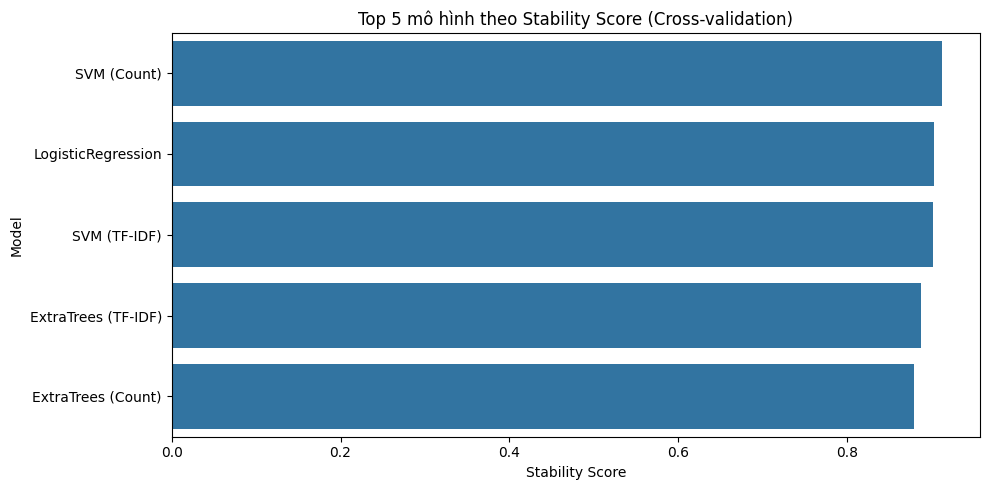


Top 5 mô hình dựa trên F1-score trên tập test:


,Feature,Model,Accuracy,Precision,Recall,F1-score
21,TF-IDF,XGBoost,0.975785,0.948905,0.866667,0.905923
1,Count,LogisticRegression,0.976682,1.000000,0.826667,0.905109
19,TF-IDF,ExtraTrees,0.976682,1.000000,0.826667,0.905109
13,TF-IDF,SVM,0.975785,0.976744,0.840000,0.903226
8,Count,ExtraTrees,0.975785,1.000000,0.820000,0.901099


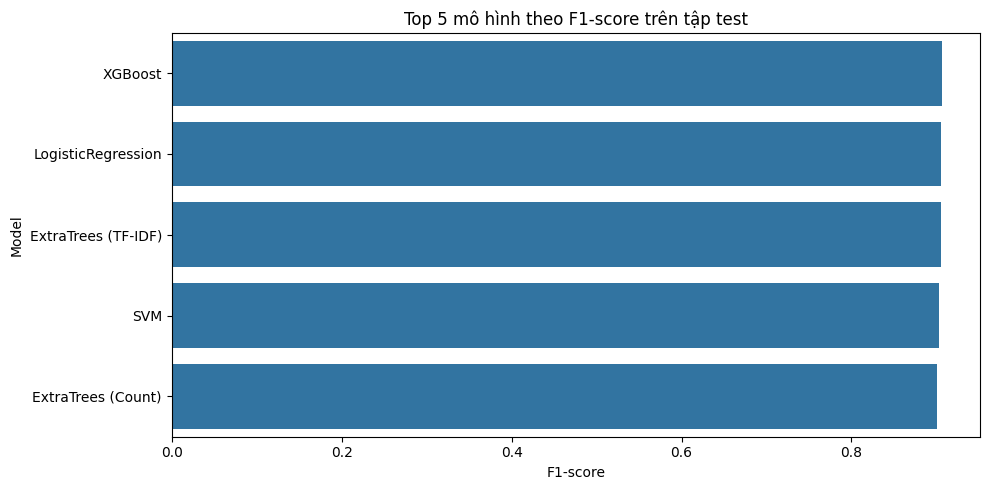


Top 5 mô hình dựa trên Composite Score:


,Feature,Model,Stability Score,F1-score,Composite Score
1,Count,LogisticRegression,0.903244,0.905109,0.904177
13,TF-IDF,SVM,0.902053,0.903226,0.902639
2,Count,SVM,0.911781,0.888889,0.900335
19,TF-IDF,ExtraTrees,0.887964,0.905109,0.896537
8,Count,ExtraTrees,0.879626,0.901099,0.890362


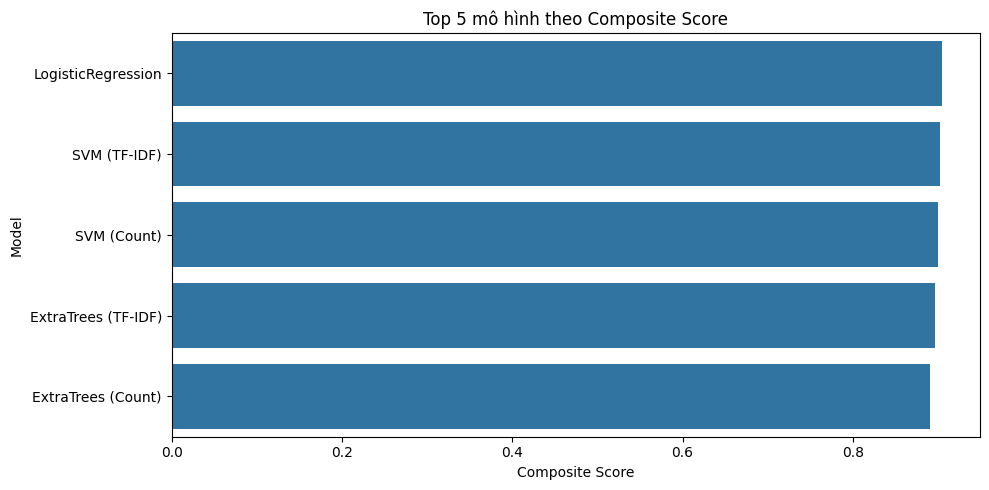

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Hiển thị top 5 mô hình dựa trên Stability Score, F1-score trên tập test, và Composite Score

# 1. Top 5 mô hình dựa trên Stability Score từ Cross-validation
top5_stability = df_cv_results.sort_values('Stability Score', ascending=False).head(5)
print("\nTop 5 mô hình dựa trên Stability Score (Cross-validation):")
display(top5_stability[['Feature', 'Model', 'Mean F1-score', 'Std F1-score', 'Stability Score']])

# Tạo cột mới cho trục y: chỉ thêm feature khi mô hình trùng tên
top5_stability['Model_Feature'] = top5_stability.apply(
    lambda row: f"{row['Model']} ({row['Feature']})" if top5_stability['Model'].duplicated(keep=False).loc[row.name] else row['Model'],
    axis=1
)

# Vẽ biểu đồ cho top 5 Stability Score
plt.figure(figsize=(10, 5))
sns.barplot(data=top5_stability, x='Stability Score', y='Model_Feature')
plt.title("Top 5 mô hình theo Stability Score (Cross-validation)")
plt.xlabel("Stability Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# 2. Top 5 mô hình dựa trên F1-score từ tập test
top5_f1_test = df_results.sort_values('F1-score', ascending=False).head(5)
print("\nTop 5 mô hình dựa trên F1-score trên tập test:")
display(top5_f1_test[['Feature', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']])

# Tạo cột mới cho trục y: chỉ thêm feature khi mô hình trùng tên
top5_f1_test['Model_Feature'] = top5_f1_test.apply(
    lambda row: f"{row['Model']} ({row['Feature']})" if top5_f1_test['Model'].duplicated(keep=False).loc[row.name] else row['Model'],
    axis=1
)

# Vẽ biểu đồ cho top 5 F1-score trên tập test
plt.figure(figsize=(10, 5))
sns.barplot(data=top5_f1_test, x='F1-score', y='Model_Feature')
plt.title("Top 5 mô hình theo F1-score trên tập test")
plt.xlabel("F1-score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# 3. Tính Composite Score và hiển thị top 5
combined_results = pd.merge(df_cv_results[['Feature', 'Model', 'Stability Score']],
                            df_results[['Feature', 'Model', 'F1-score']],
                            on=['Feature', 'Model'],
                            how='inner')
combined_results['Composite Score'] = 0.5 * combined_results['Stability Score'] + 0.5 * combined_results['F1-score']
top5_composite = combined_results.sort_values('Composite Score', ascending=False).head(5)
print("\nTop 5 mô hình dựa trên Composite Score:")
display(top5_composite[['Feature', 'Model', 'Stability Score', 'F1-score', 'Composite Score']])

# Tạo cột mới cho trục y: chỉ thêm feature khi mô hình trùng tên
top5_composite['Model_Feature'] = top5_composite.apply(
    lambda row: f"{row['Model']} ({row['Feature']})" if top5_composite['Model'].duplicated(keep=False).loc[row.name] else row['Model'],
    axis=1
)

# Vẽ biểu đồ cho top 5 Composite Score
plt.figure(figsize=(10, 5))
sns.barplot(data=top5_composite, x='Composite Score', y='Model_Feature')
plt.title("Top 5 mô hình theo Composite Score")
plt.xlabel("Composite Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

Confusion Matrix cho 3 model tối ưu nhất


Model: LogisticRegression trên Count (Stability Score=0.9032, F1-test=0.9051, Composite Score=0.9042)


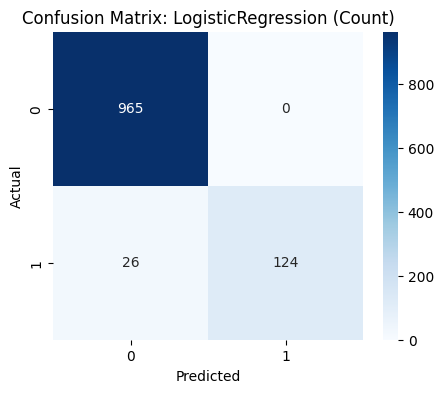


Model: SVM trên TF-IDF (Stability Score=0.9021, F1-test=0.9032, Composite Score=0.9026)


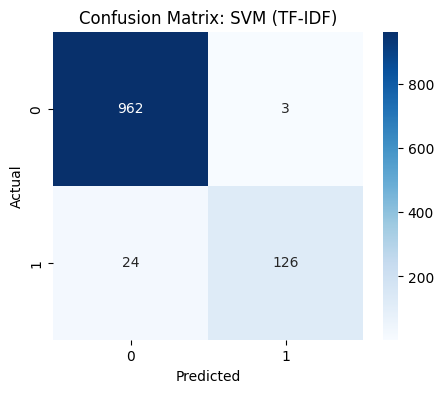


Model: SVM trên Count (Stability Score=0.9118, F1-test=0.8889, Composite Score=0.9003)


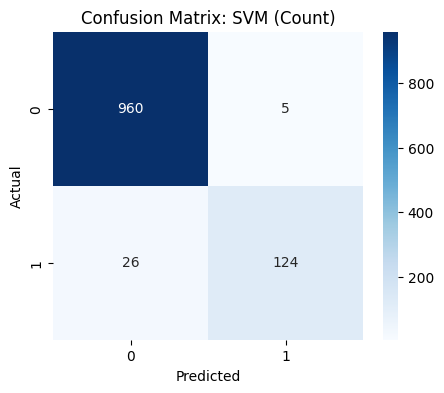

In [28]:
# Sử dụng top 3 từ Composite Score để vẽ ma trận nhầm lẫn
top3_overall = top5_composite.head(3)

for index, row in top3_overall.iterrows():
    model_name = row['Model']
    feat = row['Feature']
    stability_score = row['Stability Score']
    f1_test = row['F1-score']
    composite_score = row['Composite Score']

    print(f"\nModel: {model_name} trên {feat} (Stability Score={stability_score:.4f}, F1-test={f1_test:.4f}, Composite Score={composite_score:.4f})")

    # Chọn dữ liệu train/test dựa trên đặc trưng
    best_model = models[model_name]
    if feat == 'TF-IDF':
        X_tr, X_te, y_tr, y_te = X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test
    else:
        X_tr, X_te, y_tr, y_te = X_count_train, X_count_test, y_count_train, y_count_test

    # Huấn luyện mô hình và dự đoán
    best_model.fit(X_tr, y_tr)
    y_pred = best_model.predict(X_te)
    cm = confusion_matrix(y_te, y_pred)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model_name} ({feat})')
    plt.show()

Lưu lại model tốt nhất

In [29]:
with open('best_spam_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Đã lưu mô hình tốt nhất vào best_spam_model.pkl")

Đã lưu mô hình tốt nhất vào best_spam_model.pkl
